<a href="https://colab.research.google.com/github/smallriver0316/python-datascience-study/blob/development/hog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0.5, 1.0, 'visualization of HOG features')

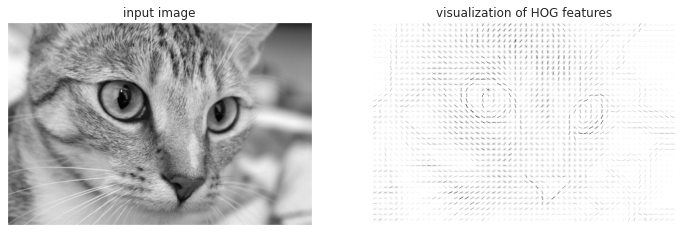

In [3]:
# Histgram of Gradients
from skimage import data, color, feature

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis, cmap='gray_r')
ax[1].set_title('visualization of HOG features')

In [4]:
# HOG特徴量を利用した機械学習
# 顔認識
from sklearn.datasets import fetch_lfw_people

# 1. 「陽性」学習サンプルを構成する顔の画像サムネイルセットを取得
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [6]:
# 2. 「陰性」学習サンプルを構成する画像サムネイルセットを取得する
# 入力画像のあらゆるコーパスから、様々な尺度でサムネイルを抽出することで、顔画像ではない同様のサイズのサムネイルセットを取得する
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock',
               'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [9]:
from skimage import transform
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
  extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
  extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
  patches = extractor.transform(img[np.newaxis])
  if scale != 1:
    patches = np.array([transform.resize(patch, patch_size) for patch in patches])
  return patches

In [10]:
negative_patches = np.vstack([extract_patches(img, 1000, scale) for img in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

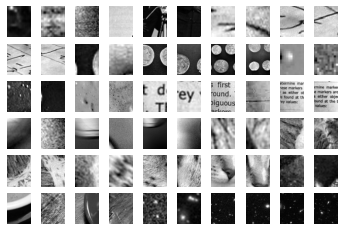

In [12]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
  axi.imshow(negative_patches[500 * i], cmap='gray')
  axi.axis('off')

In [14]:
# 3. 集めた学習データからHOG特徴量を抽出
from itertools import chain
X_train = np.array([feature.hog(img) for img in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [15]:
X_train.shape

(43233, 1215)

In [16]:
# 4. 線形SVMによる学習
# 単純なガウシアンナイーブベイズを試す
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94772754, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [17]:
# SVMを試す
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9884347203194052

In [20]:
grid.best_params_

{'C': 1.0}

In [21]:
# 最良のモデルで学習
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

(-0.5, 139.5, 159.5, -0.5)

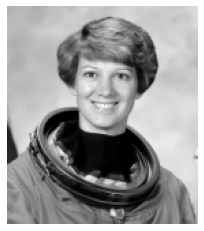

In [22]:
# テスト画像を準備
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
# 今回は簡略化のため画像の一部だけを切り出す
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [23]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
  Ni, Nj = (int(scale * s) for s in patch_size)
  for i in range(0, img.shape[0] - Ni, istep):
    for j in range(0, img.shape[1] - Nj, jstep):
      patch = img[i:i + Ni, j:j+Nj]
      if scale != 1:
        patch = transform.resize(patch, patch_size)
      yield (i, j), patch

In [24]:
# indicesは画像位置、patchesはindicesの各画素位置を起点とするwindowのサイズ
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [25]:
labels = model.predict(patches_hog)
labels.sum()

49.0

In [31]:
print(labels.shape)
print(labels[:10])

(2303,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


49個の顔を含むと判断されたウィンドウを得られた

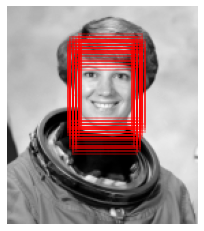

In [26]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

In [27]:
indices.shape

(2303, 2)

In [28]:
indices[:10]

array([[ 0,  0],
       [ 0,  2],
       [ 0,  4],
       [ 0,  6],
       [ 0,  8],
       [ 0, 10],
       [ 0, 12],
       [ 0, 14],
       [ 0, 16],
       [ 0, 18]])

In [29]:
positive_patches[0].shape

(62, 47)

In [30]:
Ni, Nj = (int(1.0 * s) for s in positive_patches[0].shape)
print('Ni = ', Ni)
print('Nj = ', Nj)

Ni =  62
Nj =  47


In [35]:
patches[:3]

(array([[0.6598141 , 0.6660879 , 0.67369836, ..., 0.71322437, 0.71077283,
         0.70775606],
        [0.65943555, 0.66326406, 0.66263756, ..., 0.71501127, 0.70880288,
         0.70410541],
        [0.65866283, 0.66642104, 0.66821404, ..., 0.72605317, 0.72260478,
         0.71089796],
        ...,
        [0.70067299, 0.69818431, 0.69826602, ..., 0.65422849, 0.47164443,
         0.47994034],
        [0.69949194, 0.69752761, 0.69653429, ..., 0.7702125 , 0.61459059,
         0.59805983],
        [0.696637  , 0.7019337 , 0.6960088 , ..., 0.79107937, 0.73001149,
         0.69924307]]),
 array([[0.67369836, 0.66898327, 0.67209734, ..., 0.70775606, 0.69830908,
         0.70701679],
        [0.66263756, 0.67026249, 0.66972567, ..., 0.70410541, 0.69882569,
         0.70694223],
        [0.66821404, 0.675317  , 0.67661804, ..., 0.71089796, 0.71584369,
         0.71402887],
        ...,
        [0.69826602, 0.69665106, 0.69700188, ..., 0.47994034, 0.464387  ,
         0.3860015 ],
        [0.6

- sliding windowのサイズは学習データの62x47としている